In [45]:
import tensorflow as tf
import cv2
import numpy as np
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
import random


In [46]:
# Read Normal Boxes

In [47]:
img_size = 256

In [48]:
# read dir path
filepaths = []

for i in ["boxes","packages","paper_boxes"]:
    folder = "/Users/tunchiehhsu/Desktop/googliser/googliser/" + i
    for file in os.listdir(folder):
            if file != ".DS_Store":
                filepath = os.path.join(folder, file)
                filepaths.append(filepath)
x_normal = []
for path in filepaths:
    # gray scale
    img = io.imread(path,as_gray = True)
    # reshape to uniform size
    reshape_img = cv2.resize(img, dsize=(img_size, img_size), interpolation=cv2.INTER_CUBIC)
    x_normal.append(reshape_img.flatten())
x_normal = np.array(x_normal) # trans to Array 

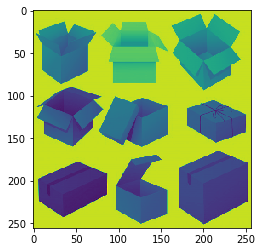

In [49]:
plt.imshow(x_normal[30].reshape([img_size,img_size]));


In [50]:
len(filepaths) # Amt of normal boxes

366

In [51]:
# Read Smashed Boxes

In [52]:
# read dir path
filepaths = []
for i in ["broken_boxes","damaged_boxes","damaged_packages","smashed_boxes"]:
    folder = "/Users/tunchiehhsu/Desktop/googliser/googliser/" + i
    for file in os.listdir(folder):
            if file != ".DS_Store":
                filepath = os.path.join(folder, file)
                filepaths.append(filepath)
x_smashed = []
for path in filepaths:
    # gray scale
    img = io.imread(path,as_gray = True)
    # reshape to uniform size
    reshape_img = cv2.resize(img, dsize=(img_size,img_size), interpolation=cv2.INTER_CUBIC)
    x_smashed.append(reshape_img.flatten())
x_smashed = np.array(x_smashed) # trans to Array 

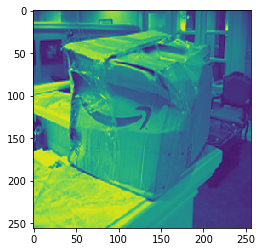

In [53]:
plt.imshow(x_smashed[1].reshape([img_size,img_size]));

In [54]:
len(x_smashed) # amt of smashed boxes

224

In [55]:
def conv2d(x,num_outputs):
    return tf.contrib.layers.conv2d(x, num_outputs = num_outputs, kernel_size = [3,3], stride = [1,1], 
                                    padding = "SAME", activation_fn = tf.nn.leaky_relu)

def max_pool_2x2(x):
    return tf.contrib.layers.max_pool2d(x, kernel_size = [3,3], stride = [2,2], padding = "SAME")

In [61]:
# define placeholder for inputs to network
tf.reset_default_graph()
xs = tf.placeholder(tf.float32, [None, img_size * img_size]) # 500 x 500

# transfer label to one_hot
ys = tf.placeholder(tf.float32, [None,1])

keep_prob = tf.placeholder(tf.float32)
x_image = tf.reshape(xs, [-1, img_size,img_size, 1])

#Combine
h_conv1 = tf.contrib.layers.conv2d(x_image,32,kernel_size = [5,5],stride = [2,2]) # 128 x 128 x 32
h_conv1 = conv2d(h_conv1,32) 
h_pool1 = max_pool_2x2(h_conv1) # 64 x 64 x 32

#Combine
h_conv2 = conv2d(h_pool1,64)  
h_conv2 = conv2d(h_conv2,64) 
h_pool2 = max_pool_2x2(h_conv2) 

#Combine
h_conv3 = conv2d(h_pool2,96) 
h_conv3 = conv2d(h_conv3,96) 
h_pool3 = max_pool_2x2(h_conv3) 
#Combine
h_conv4 = conv2d(h_pool3,128) 
h_conv4 = conv2d(h_conv4,128) 
h_pool4 = tf.contrib.layers.avg_pool2d(h_conv4,kernel_size = [3,3],stride = [2,2]) #output size 8 x 8 x 128

h_flat = tf.contrib.layers.flatten(h_pool4)
fc1 = tf.contrib.layers.fully_connected(h_flat,1024,activation_fn = tf.nn.leaky_relu)
fc2 = tf.contrib.layers.fully_connected(fc1,256,activation_fn = tf.nn.leaky_relu)

fc2 = tf.contrib.layers.fully_connected(fc2,1,activation_fn = None)
prediction = tf.nn.sigmoid(fc2,name="Probability")

with tf.name_scope("Accuracy"):
    correct_number = tf.equal(tf.cast(tf.greater(prediction,0.5),tf.float32),ys)
    accuracy = tf.reduce_mean(tf.cast(correct_number,tf.float32))
    
with tf.name_scope("Loss"):
    
    cross_entropy = -(tf.log(tf.clip_by_value(prediction,1e-10,1)) * ys + (1-ys) * tf.log(tf.clip_by_value(1- prediction,1e-10,1)))
    loss = tf.reduce_mean(cross_entropy)

train_step = tf.train.AdamOptimizer(5e-4).minimize(loss)

init = tf.global_variables_initializer()

tf.summary.FileWriter(logdir="boxes",graph = tf.get_default_graph())

#Check localhost:6066

In [62]:
datalist = list(zip(np.ones(len(x_normal)), x_normal)) + list(zip(np.zeros(len(x_normal)), x_smashed))
train_index = random.sample(list(range(590)),int(np.floor(len(datalist) * 0.8)))

train = [datalist[i] for i in train_index]
test = [datalist[i] for i in range(590) if i not in train_index]

In [63]:
# Training Set
Y = []
X = []
for yy,xx in train:
    Y.append(int(yy))
    X.append(xx)
train_xs = np.array(X)
train_ys = np.array(Y).astype("uint8").reshape([-1,1])

# Test Set 
Y = []
X = []
for yy,xx in test:
    Y.append(int(yy))
    X.append(xx)
test_x = np.array(X)
test_y = np.array(Y).astype("uint8").astype("uint8").reshape([-1,1])

In [64]:
sess = tf.Session()
sess.run(init)


In [ ]:
r_index = np.arange(train_xs.shape[0])

for i in range(100):
    batch_idx = np.random.choice(r_index,50,replace = False)
    batch_xs , batch_ys = train_xs[batch_idx] , train_ys[batch_idx]
    sess.run(train_step, feed_dict = {xs: batch_xs, ys: batch_ys, keep_prob:0.5})
    if i % 5 == 0:
        acc = sess.run(accuracy,feed_dict={xs: test_x, ys: test_y, keep_prob:1})
        print(acc)

0.55932206
0.55932206
0.55932206
0.55932206
0.59322035
0.86440676
0.779661
0.7288136
0.86440676
0.88135594
0.779661
0.84745765
0.88135594
0.84745765
0.88135594
0.779661
0.84745765
0.7966102
